# Imports and Loading the Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import gensim

#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
# Load the data
listings = pd.read_csv('https://raw.githubusercontent.com/jphil-16/Thinkful_Projects_JDP/main/listings.csv')

In [3]:
# Drop the features that won't be used
listings = listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped',
       'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'accommodates', 'bathrooms_text', 'beds',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'neighbourhood_group_cleansed',
       'longitude', 'property_type', 'bathrooms', 'bedrooms',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'neighborhood_overview',
       'calculated_host_listings_count', 'host_response_time', 'host_is_superhost',
       'calculated_host_listings_count_entire_homes', 'amenities', 'number_of_reviews',
       'calculated_host_listings_count_private_rooms', 'review_scores_rating', 'instant_bookable', 
       'calculated_host_listings_count_shared_rooms'])

# Take a quick look at the data
listings.head()

,name,description,room_type,price,last_review,reviews_per_month
0,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Entire home/apt,$295.00,2020-02-01,0.22
1,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...",Private room,$55.00,2019-12-27,1.19
2,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,Entire home/apt,$155.00,2019-12-30,0.37
3,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,Entire home/apt,$125.00,2020-08-31,0.50
4,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...",Entire home/apt,$100.00,2020-09-28,0.85


In [4]:
# See what columns are left
listings.columns

Index(['name', 'description', 'room_type', 'price', 'last_review',
       'reviews_per_month'],
      dtype='object')

# Clean the Text Data

In [5]:
# First things first - drop the rows that have empty values
# We can afford this step because we will still have thousands of data entires
listings = listings.dropna()
listings.reset_index(drop = True, inplace = True)

In [6]:
# Clean the text
def text_cleaner(text):
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text

listings["description"] = listings["description"].apply(lambda x: text_cleaner(x))
listings["description"].head(10)

for i in range(len(listings)):
    listings.loc[i, 'description'] = listings.loc[i, 'description'].replace('<b>','')
    
for i in range(len(listings)):
    listings.loc[i, 'description'] = listings.loc[i, 'description'].replace('</b>','')
    
for i in range(len(listings)):
    listings.loc[i, 'description'] = listings.loc[i, 'description'].replace('<br />',' ')
    
for i in range(len(listings)):
    listings.loc[i, 'description'] = listings.loc[i, 'description'].replace('@','')
    
for i in range(len(listings)):
    listings.loc[i, 'description'] = listings.loc[i, 'description'].replace('*',' ')

In [7]:
# remove punctuation
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

listings["description"] = listings["description"].apply(lambda x: remove_punctuation(x))
listings["description"].tail(10)

3490    Located in South Park Seattle our AirBNB suite...
3491    Looking for an urban treehouse in Seattle Welc...
3492    This is a small narrow closet under our stairw...
3493    This is a microstudio in a building apartment ...
3494    Garden guest suite in centrally located townho...
3495    This is a big room with two queen beds in a th...
3496    The Seaboard a historic landmark  Seattle icon...
3497    come enjoy this remodeled Beautiful modern uni...
3498    NEW LISTING This updated bedroom apartment rig...
3499    A perfect private spot on one of the most char...
Name: description, dtype: object

In [8]:
# Tokenization
tokenizer = RegexpTokenizer(r'\w+')
listings["description"] = listings["description"].apply(lambda x: tokenizer.tokenize(x.lower()))
listings["description"].tail(10)

3490    [located, in, south, park, seattle, our, airbn...
3491    [looking, for, an, urban, treehouse, in, seatt...
3492    [this, is, a, small, narrow, closet, under, ou...
3493    [this, is, a, microstudio, in, a, building, ap...
3494    [garden, guest, suite, in, centrally, located,...
3495    [this, is, a, big, room, with, two, queen, bed...
3496    [the, seaboard, a, historic, landmark, seattle...
3497    [come, enjoy, this, remodeled, beautiful, mode...
3498    [new, listing, this, updated, bedroom, apartme...
3499    [a, perfect, private, spot, on, one, of, the, ...
Name: description, dtype: object

In [9]:
# Remove stop words
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

listings["description"] = listings["description"].apply(lambda x: remove_stopwords(x))
listings["description"].tail(10)

3490    [located, south, park, seattle, airbnb, suite,...
3491    [looking, urban, treehouse, seattle, welcome, ...
3492    [small, narrow, closet, stairwell, see, pictur...
3493    [microstudio, building, apartment, complex, ce...
3494    [garden, guest, suite, centrally, located, tow...
3495    [big, room, two, queen, beds, three, bedroom, ...
3496    [seaboard, historic, landmark, seattle, icon, ...
3497    [come, enjoy, remodeled, beautiful, modern, un...
3498    [new, listing, updated, bedroom, apartment, ri...
3499    [perfect, private, spot, one, charming, crafts...
Name: description, dtype: object

In [10]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

listings["description"] = listings["description"].apply(lambda x: word_lemmatizer(x))
listings["description"].tail(10)

3490    located south park seattle airbnb suite featur...
3491    looking urban treehouse seattle welcome trendy...
3492    small narrow closet stairwell see picture dime...
3493    microstudio building apartment complex central...
3494    garden guest suite centrally located townhome ...
3495    big room two queen bed three bedroom apartment...
3496    seaboard historic landmark seattle icon emerge...
3497    come enjoy remodeled beautiful modern unit sea...
3498    new listing updated bedroom apartment right ne...
3499    perfect private spot one charming craftsmanfil...
Name: description, dtype: object

# Clean the Numerical Data

In [11]:
# Next we have to transform numerical columns that are currently in string form

# The listing price needs to be converted from a string to a number
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# The "last review" date needs the first 4 digits extracted to give us the year of the last review
# We will use this to filter out abandoned listings later on
year_last_review = pd.DataFrame([listings.loc[i,'last_review'][:4] for i in range(len(listings))])
year_last_review.columns = ['year_last_review']
listings = pd.concat([listings, year_last_review], axis = 1, sort = False)

In [12]:
# Now we need to filter out data that we don't want

# Filter on price first
# Drop rows with expensive listings (We will use $400 as a manual cut-off)
index_names_highprice = listings[listings['price'] > 400 ].index 
listings.drop(index_names_highprice, inplace = True)

# Filter on last review date
# Drop rows with no recent reviews (which represent abandoned listings)
index_names_old = listings[listings['year_last_review'] != '2020' ].index 
listings.drop(index_names_old, inplace = True)

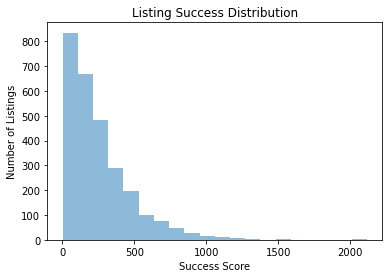

In [13]:
# Create a new column that represents the success of the listing
listings['success_score'] = listings['price'] * listings['reviews_per_month']

# Take a quick look at how the target variable is distrubted
plt.hist(listings['success_score'], alpha = .5, bins = 20)
plt.title('Listing Success Distribution')
plt.xlabel('Success Score')
plt.ylabel('Number of Listings')
plt.show()

In [14]:
# bucket the target variable to be categorical

listings = listings.reset_index(drop=True)
for i in range(len(listings)):
    if listings.loc[i,'success_score'] > 500:
        listings.loc[i, 'success_score'] = "high"
    elif listings.loc[i, 'success_score'] < 350:
        listings.loc[i, 'success_score'] = "low"
    else:
        listings.loc[i, 'success_score'] = "med"

In [15]:
# Drop the columns that are no longer used
listings = listings.drop(columns=['room_type', 'price', 'year_last_review', 'reviews_per_month', 'last_review'])

In [16]:
# Let's take another quick look at what our data looks like after all that...
listings.head(10)

,name,description,success_score
0,Casa Madrona - Urban Oasis 1 block from the park!,gorgeous architect remodeled dutch colonial he...,low
1,The Coolest Tangerine Dream MIL!,welcome delicious tangerine dream colorful coz...,low
2,"the down home , spacious, central and fab!",great neighborhood quiet full garden walkabili...,low
3,"the orange house, quiet 'n central",space wonderful designer decorated bungalow ha...,low
4,Stylish Oasis in a Prime Location in Belltown,step onto private balcony condo peekaboo view ...,low
5,"Beautiful, Private Spot in Quiet Ballard",social distancing extra covid precaution place...,med
6,Cozy Ballard Apartment,enjoy simple apartment beautiful ballard neigh...,low
7,Your Home Away From Home. Private Parking ons...,live like local seattle ballard private place ...,low
8,green suite seattle - dog friendly,space quiet ecofriendly get away family friend...,low
9,"Light and airy, steps to the Lake.",offer clean well maintained guest suite family...,low


# Use BoW to Convert the Text Features and generate models

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(listings["description"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
descriptions = pd.concat([bow_df, listings[["description", "success_score"]]], axis=1)
descriptions = descriptions.dropna()

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

Y = descriptions['success_score']
X = np.array(descriptions.drop(['description','success_score'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9957805907172996

Test set score: 0.7289972899728997
----------------------Random Forest Scores----------------------
Training set score: 0.9963833634719711

Test set score: 0.7651309846431797
----------------------Gradient Boosting Scores----------------------
Training set score: 0.805304400241109

Test set score: 0.7479674796747967


# Use TF-IDF to Convert the Text Features and generate models

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)


# Applying the vectorizer
X = vectorizer.fit_transform(listings["description"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
descriptions = pd.concat([bow_df, listings[["description", "success_score"]]], axis=1)
descriptions = descriptions.dropna()

In [20]:
Y = descriptions['success_score']
X = np.array(descriptions.drop(['description','success_score'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9957805907172996

Test set score: 0.7289972899728997
----------------------Random Forest Scores----------------------
Training set score: 0.9963833634719711

Test set score: 0.7642276422764228
----------------------Gradient Boosting Scores----------------------
Training set score: 0.8059071729957806

Test set score: 0.7506775067750677


# Use word2vec to Convert the Text Features and generate models

In [21]:
# Train word2vec on the descriptions
model = gensim.models.Word2Vec(
    descriptions["description"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

In [25]:
word2vec_arr = np.zeros((descriptions.shape[0],100))

for i, desc in enumerate(descriptions["description"]):
    word2vec_arr[i,:] = np.mean([model[lemma] for lemma in desc], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
descriptions = pd.concat([bow_df, listings[["description", "success_score"]]], axis=1)
descriptions = descriptions.dropna()

In [26]:
Y = descriptions['success_score']
X = np.array(descriptions.drop(['description','success_score'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9957805907172996

Test set score: 0.7289972899728997
----------------------Random Forest Scores----------------------
Training set score: 0.9963833634719711

Test set score: 0.7633242999096658
----------------------Gradient Boosting Scores----------------------
Training set score: 0.8071127185051236

Test set score: 0.7497741644083108


# See the most common words in each success group

In [46]:
# High success
pd.options.display.float_format = "{:,.2f}".format

high_success = descriptions.loc[descriptions['success_score'] == 'high'].reset_index(drop=True)
high_success.drop(columns=['description','success_score'])
high_word_sums = high_success.sum(axis=0)
high_word_sums = high_word_sums.to_frame('ratio - high')
high_word_sums.drop(high_word_sums.tail(2).index,inplace=True)
high_word_sums['ratio - high'] = high_word_sums['ratio - high'] / len(high_success)

most_used_high = high_word_sums[high_word_sums['ratio - high'] > 0.1]
most_used_high.sort_values('ratio - high', inplace=True, ascending=False)
most_used_high.head(10)

,ratio - high
space,1.56
seattle,1.16
guest,0.86
home,0.76
bed,0.72
access,0.69
bedroom,0.68
kitchen,0.65
downtown,0.62
room,0.60


<AxesSubplot:>

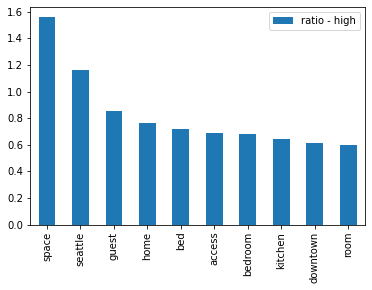

In [47]:
most_used_high.head(10).plot(kind='bar')

In [32]:
# Low success
low_success = descriptions.loc[descriptions['success_score'] == 'low'].reset_index(drop=True)
low_success.drop(columns=['description','success_score'])
low_word_sums = low_success.sum(axis=0)
low_word_sums = low_word_sums.to_frame('ratio - low')
low_word_sums.drop(low_word_sums.tail(2).index,inplace=True)
low_word_sums['ratio - low'] = low_word_sums['ratio - low'] / len(low_success)

most_used_low = low_word_sums[low_word_sums['ratio - low'] > 0.1]
most_used_low.sort_values('ratio - low', inplace=True, ascending=False)
most_used_low.head(10)

,ratio - low
space,1.65
seattle,1.19
guest,1.00
room,0.92
home,0.81
private,0.80
access,0.79
kitchen,0.77
bed,0.74
bedroom,0.73


<AxesSubplot:>

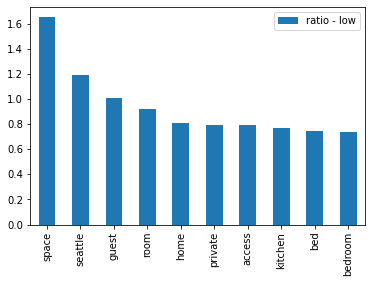

In [48]:
most_used_low.head(10).plot(kind='bar')

In [29]:
# Compare
comparison = pd.concat([high_word_sums, low_word_sums], axis=1)
comparison['difference'] = comparison['ratio - high'] - comparison['ratio - low']

best_words = comparison[comparison['difference'] > 0.05]
best_words.sort_values('difference', inplace=True, ascending=False)
best_words.head(10)

,ratio - high,ratio - low,difference
view,0.593846,0.334291,0.259555
rooftop,0.166154,0.0608238,0.10533
license,0.332308,0.237548,0.0947598
number,0.338462,0.244732,0.0937297
stropli,0.289231,0.203544,0.0856867
entire,0.178462,0.0996169,0.0788447
deck,0.246154,0.170498,0.0756558
tv,0.396923,0.323276,0.0736472
water,0.163077,0.0905172,0.0725597
master,0.135385,0.0646552,0.0707294


<AxesSubplot:>

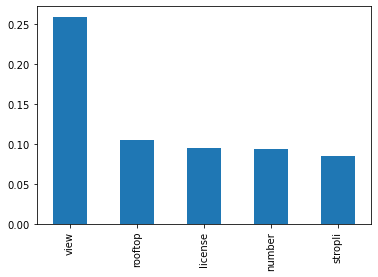

In [57]:
best_words['difference'].head(5).plot(kind='bar')

In [30]:
worst_words = comparison[comparison['difference'] < -0.05]
worst_words.sort_values('difference', inplace=True)
worst_words.head(10)

,ratio - high,ratio - low,difference
room,0.6,0.921935,-0.321935
private,0.569231,0.796456,-0.227225
apartment,0.449231,0.641762,-0.192532
bathroom,0.341538,0.506226,-0.164688
entrance,0.156923,0.306034,-0.149111
guest,0.855385,1.00383,-0.148447
bus,0.175385,0.321839,-0.146454
shared,0.0676923,0.201149,-0.133457
kitchen,0.646154,0.76772,-0.121566
garden,0.0830769,0.191571,-0.108494


<AxesSubplot:>

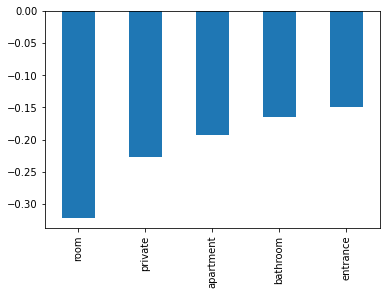

In [56]:
worst_words['difference'].head(5).plot(kind='bar')